# Caso Practico 4.5:  Clasificación de Tendencias Políticas en Twitter



* En este notebook vamos a tener como ***dataset*** un conjunto de ***tweets etiquetados con el nombre de un partido político***.


* Con estos ***tweets***; una vez ***Normalizados*** y creada la ***bolsa de palabras***, vamos a ***crear y evaluar*** una serie de ***modelos creados con Algoritmos de Aprendizaje de Clasificación***.


* Realizaremos las siguientes acciones:

    1. Carga de los datos (tweets)
    2. Normalización (en ingles) de los tweets
    3. Creación de la Bolsa de Palabras
    4. Particionado de Datos
    5. Creación de modelos: A REALIZAR POR EL ALUMNO
        - Multinomial Naive Bayes
        - Bernoulli Naive Bayes
        - Regresion Logistica
        - Support Vector Machine
        - Random Forest <sup>(*)Meta-Modelo</sup>
    6. Evaluación de los modelos


<hr>


## Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. 


* Este fichero lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos (solo seleccionamos algunas cuentas de twitter representativas) y mostramos una muestra:

In [1]:
import pandas as pd

TWEETS_FILE = './data/tweets_politica_5P.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python')

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Filtramos las cuentas de los partidos politicos y representantes
CUENTAS = ["PSOE", "sanchezcastejon",
           "populares", "pablocasado_",
           "vox_es", "Santi_ABASCAL", "Jorgebuxade",
           "PODEMOS", "PabloIglesias", "MiguelUrban", "pnique", "TeresaRodr_",
           "CiudadanosCs", "InesArrimadas"]
df = df[df['cuenta'].isin(CUENTAS)]

# Imprimimos el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets Cargados: 99632
Número de Tweets a procesar: 37677


,cuenta,partido,timestamp,tweet
80046,PODEMOS,podemos,1.589616e+09,"📽️@Yolanda_Diaz_: ""Creo que en la vida y en la..."
91764,PSOE,psoe,1.593618e+09,👉🏼 NO te pierdas esta tarde la entrevista a la...
48126,PabloIglesias,podemos,1.581586e+09,@pvallin @angel_munarriz @_infoLibre Por fin a...
61731,TeresaRodr_,podemos,1.585166e+09,Recordad esta lista cuando apliquen un ERTE pa...
22781,CiudadanosCs,ciudadanos,1.571728e+09,🏛️ Antes del inicio de la #DiputaciónPermanent...
53916,PSOE,psoe,1.583395e+09,📺 @LuisPlanas Yo protejo los intereses de nues...
21986,PSOE,psoe,1.571483e+09,🗞 @abalosmeco: “La respuesta en Cataluña va a ...
87953,sanchezcastejon,psoe,1.592143e+09,El machismo nos ha arrebatado hoy tres vidas. ...
49437,sanchezcastejon,psoe,1.582044e+09,"¡Enhorabuena, @susanadiaz, por la mejor de las..."
64972,TeresaRodr_,podemos,1.585849e+09,@InaquiJovellano Yo puedo hablar de aquello en...


* Para esta PoC vamos a utilizar solo el '***Tweet***' y el '***Partido Político***' asociado al tweet.

In [2]:
tweets = [tuple(x) for x in df[['tweet', 'partido']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 37677


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un PoC didáctica se ha realizado una normalización '*sencilla*'.

In [3]:
import numpy as np
import spacy
nlp = spacy.load('es_core_news_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = np.array([doc[1] for doc in tweets])

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        sentense = nlp(sentense.lower().replace('.', ' ').replace('#', ' ').strip())
        # Puntos 4,5,6,7 y 8
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop) 
                                     and (not word.text.startswith('@')) 
                                     and (not word.text.startswith('http'))
                                     and (not ':' in word.text)])
    return sentenses

# Normalizamos las frases
X_norm = normalize(X)

<hr>


## Bolsa de palabras

* Pasamos a construir una bolsa de palabras de frecuencias.


* Vamos a utilizar (para construir la bolsa de palabras) la clase "*CountVectorizer*" de scikit, quedandonos con:
    - Las 1000 palabras más frecuentes.
    - Que las palabras aparezcan por los menos en 5 tweets.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, min_df=5)
vectorizer.fit_transform(X_norm)

# Pasamos los tweets normalizados a Bolsa de palabras
X_bow = vectorizer.transform(X_norm)

<hr>


## Particionado de Datos (Train y Test)

* Vamos a particionar los datos en conjunto de Train y Test.


* Para este ejemplo nos vamos a quedar con:
    - 80% de datos de entrenamiento
    - 20% de datos de test

In [5]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=0)

print('Número de Tweets para el entrenamiento: {num}'.format(num=X_train.shape[0]))
print('Número de Tweets para el test: {num}'.format(num=X_test.shape[0]))

Número de Tweets para el entrenamiento: 30141
Número de Tweets para el test: 7536


<hr>


## Creacción de Modelos y Evaluación (Accuracy)


* Vamos a crear y evaluar una serie de modelos para ver cual es que obtiene mejores resultados.


* Los modelos que vamos a crear y evaluar son los siguientes:
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
    - Regresion Logistica
    - Support Vector Machine
    - Random Forest
    

* Para simplificar el problema solo vamos a evaluar los modelos (***Cross Validation***) con el accuracy y nos quedaremos con el modelo que mejor accuracy tenga.


In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


mnb = DummyClassifier() # TODO Quitar el clasificador aleatorio y poner el MultinomialNB
bnb = DummyClassifier() # TODO Quitar el clasificador aleatorio y poner el BernoulliNB
lr = DummyClassifier() # TODO Quitar el clasificador aleatorio y poner el LogisticRegression
svm_lin = DummyClassifier() # TODO Quitar el clasificador aleatorio y poner el SVM con kernel lineal
svm_rbf = DummyClassifier() # TODO Quitar el clasificador aleatorio y poner el SVM con kernel gaussiano
rf = DummyClassifier() # TODO Quitar el clasificador aleatorio y poner el Random Forest

clasificadores = {'Multinomial NB': mnb,
                  'Bernoulli NB': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM Kernel rbf': svm_rbf,
                  'Random Forest': rf}


# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    v.fit(X_train, y_train)

CREANDO MODELO: Multinomial NB
CREANDO MODELO: Bernoulli NB
CREANDO MODELO: Regresion Logistica
CREANDO MODELO: SVM lineal
CREANDO MODELO: SVM Kernel rbf
CREANDO MODELO: Random Forest


<hr>


## Evaluación del Modelo


* Para cada uno de los modelos vamos a calcular las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **Precision**
    3. **Recall**
    4. **F1**

In [7]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

def evaluation(model, name, X_train, y_train, X_test, y_test):
    """
    Función de devuelve en un diccionario las métricas de evaluación de 
    Accuracy, Precision, Recall y F1 para los conjuntos de datos de entrenamiento y test
        model: modelo a evaluar
        name: nombre del modelo
        X_train: Variables de entrada del conjunto de datos de entrenamiento
        y_train: Variable de salida del conjunto de datos de entrenamiento
        X_test: Variables de entrada del conjunto de datos de test
        y_test: Variable de salida del conjunto de datos de test
        return: diccionario con el nombre del modelo y el valor de las métricas
    """
    model_dict = {}
    model_dict['name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    model_dict['accuracy_train'] = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['accuracy_tests'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['precision_train'] = precision_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['precision_tests'] = precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['recall_train'] = recall_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['recall_tests'] = recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['f1_train'] = f1_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['f1_tests'] = f1_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    
    return model_dict


# Calculamos las métricas de los modelos por separado
evaluacion = list()
for key, model in clasificadores.items():
    evaluacion.append(evaluation(model=model, name=key, 
                                 X_train=X_train, y_train=y_train,
                                 X_test=X_test, y_test=y_test))

# Pasamos los resultados a un DataFrame para visualizarlos mejor
df = pd.DataFrame.from_dict(evaluacion)
df.set_index("name", inplace=True)
df

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedM

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
name,,,,,,,,
Multinomial NB,0.242527,0.248938,0.058819,0.06197,0.242527,0.248938,0.094677,0.099237
Bernoulli NB,0.242527,0.248938,0.058819,0.06197,0.242527,0.248938,0.094677,0.099237
Regresion Logistica,0.242527,0.248938,0.058819,0.06197,0.242527,0.248938,0.094677,0.099237
SVM lineal,0.242527,0.248938,0.058819,0.06197,0.242527,0.248938,0.094677,0.099237
SVM Kernel rbf,0.242527,0.248938,0.058819,0.06197,0.242527,0.248938,0.094677,0.099237
Random Forest,0.242527,0.248938,0.058819,0.06197,0.242527,0.248938,0.094677,0.099237


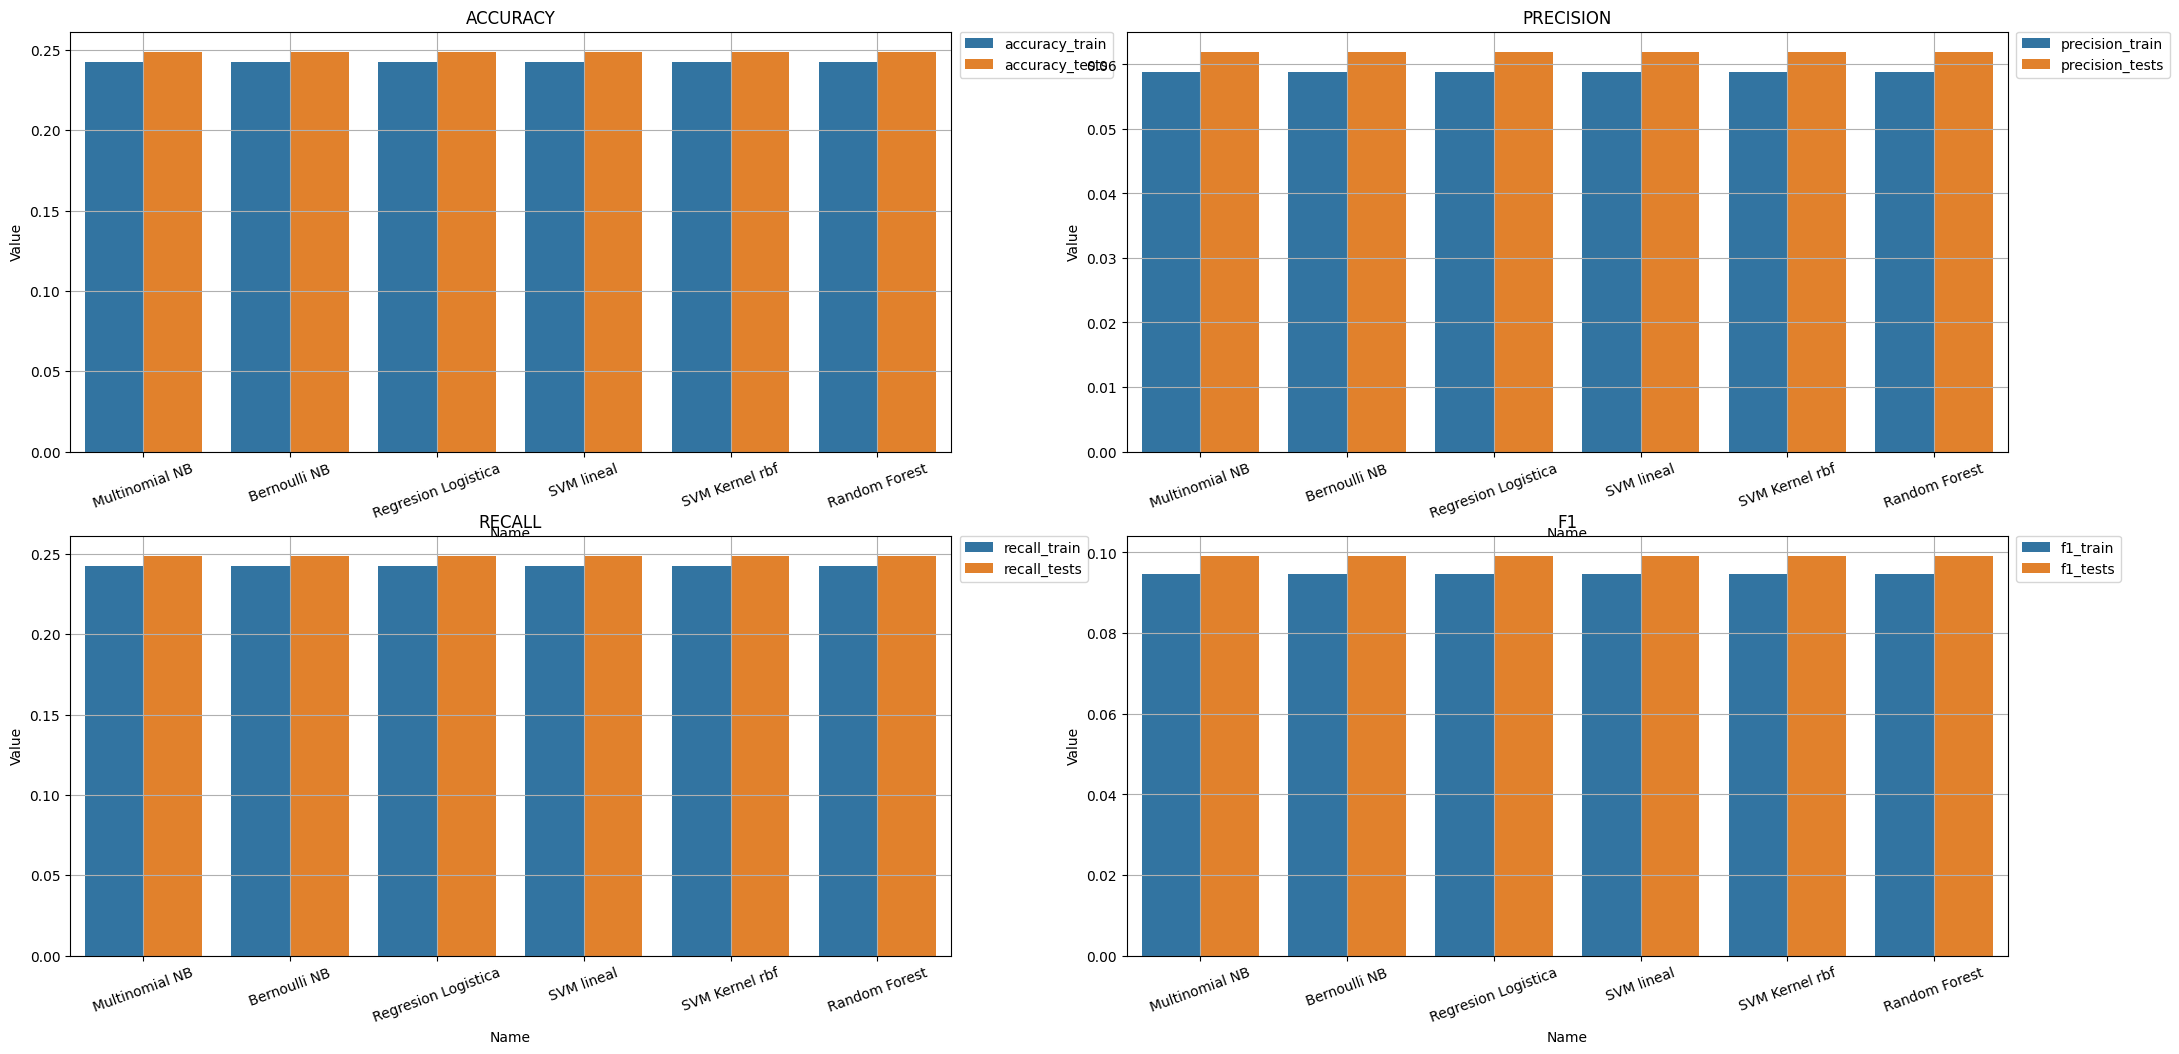

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Métricas a pintar
METRICS = ["accuracy", "precision", "recall", "f1"]

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = df.reset_index().melt(id_vars='name').rename(columns=str.title)

plt.figure(figsize=(25, 12))
pos = 1
for metric in METRICS:
    # Filtramos la métrica a pintar
    df_aux = df_plot[df_plot['Variable'].str.contains(metric)]
    
    # Pintamos la gráfica en su posición 2x2
    plt.subplot(2, 2, pos)
    sns.barplot(x='Name', y='Value', hue='Variable', data=df_aux)
    plt.title(metric.upper())
    plt.grid()
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=20)
    pos += 1
plt.show()

* Veamos las matrices de confusión de los modelos

Obteniendo Matriz de Confusión de: Multinomial NB
Obteniendo Matriz de Confusión de: Bernoulli NB
Obteniendo Matriz de Confusión de: Regresion Logistica
Obteniendo Matriz de Confusión de: SVM lineal
Obteniendo Matriz de Confusión de: SVM Kernel rbf
Obteniendo Matriz de Confusión de: Random Forest


/var/folders/cf/7nzhdlvs5nl0_zh6ky9hz9vc0000gn/T/ipykernel_2448/2505110618.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6, 2, pos)


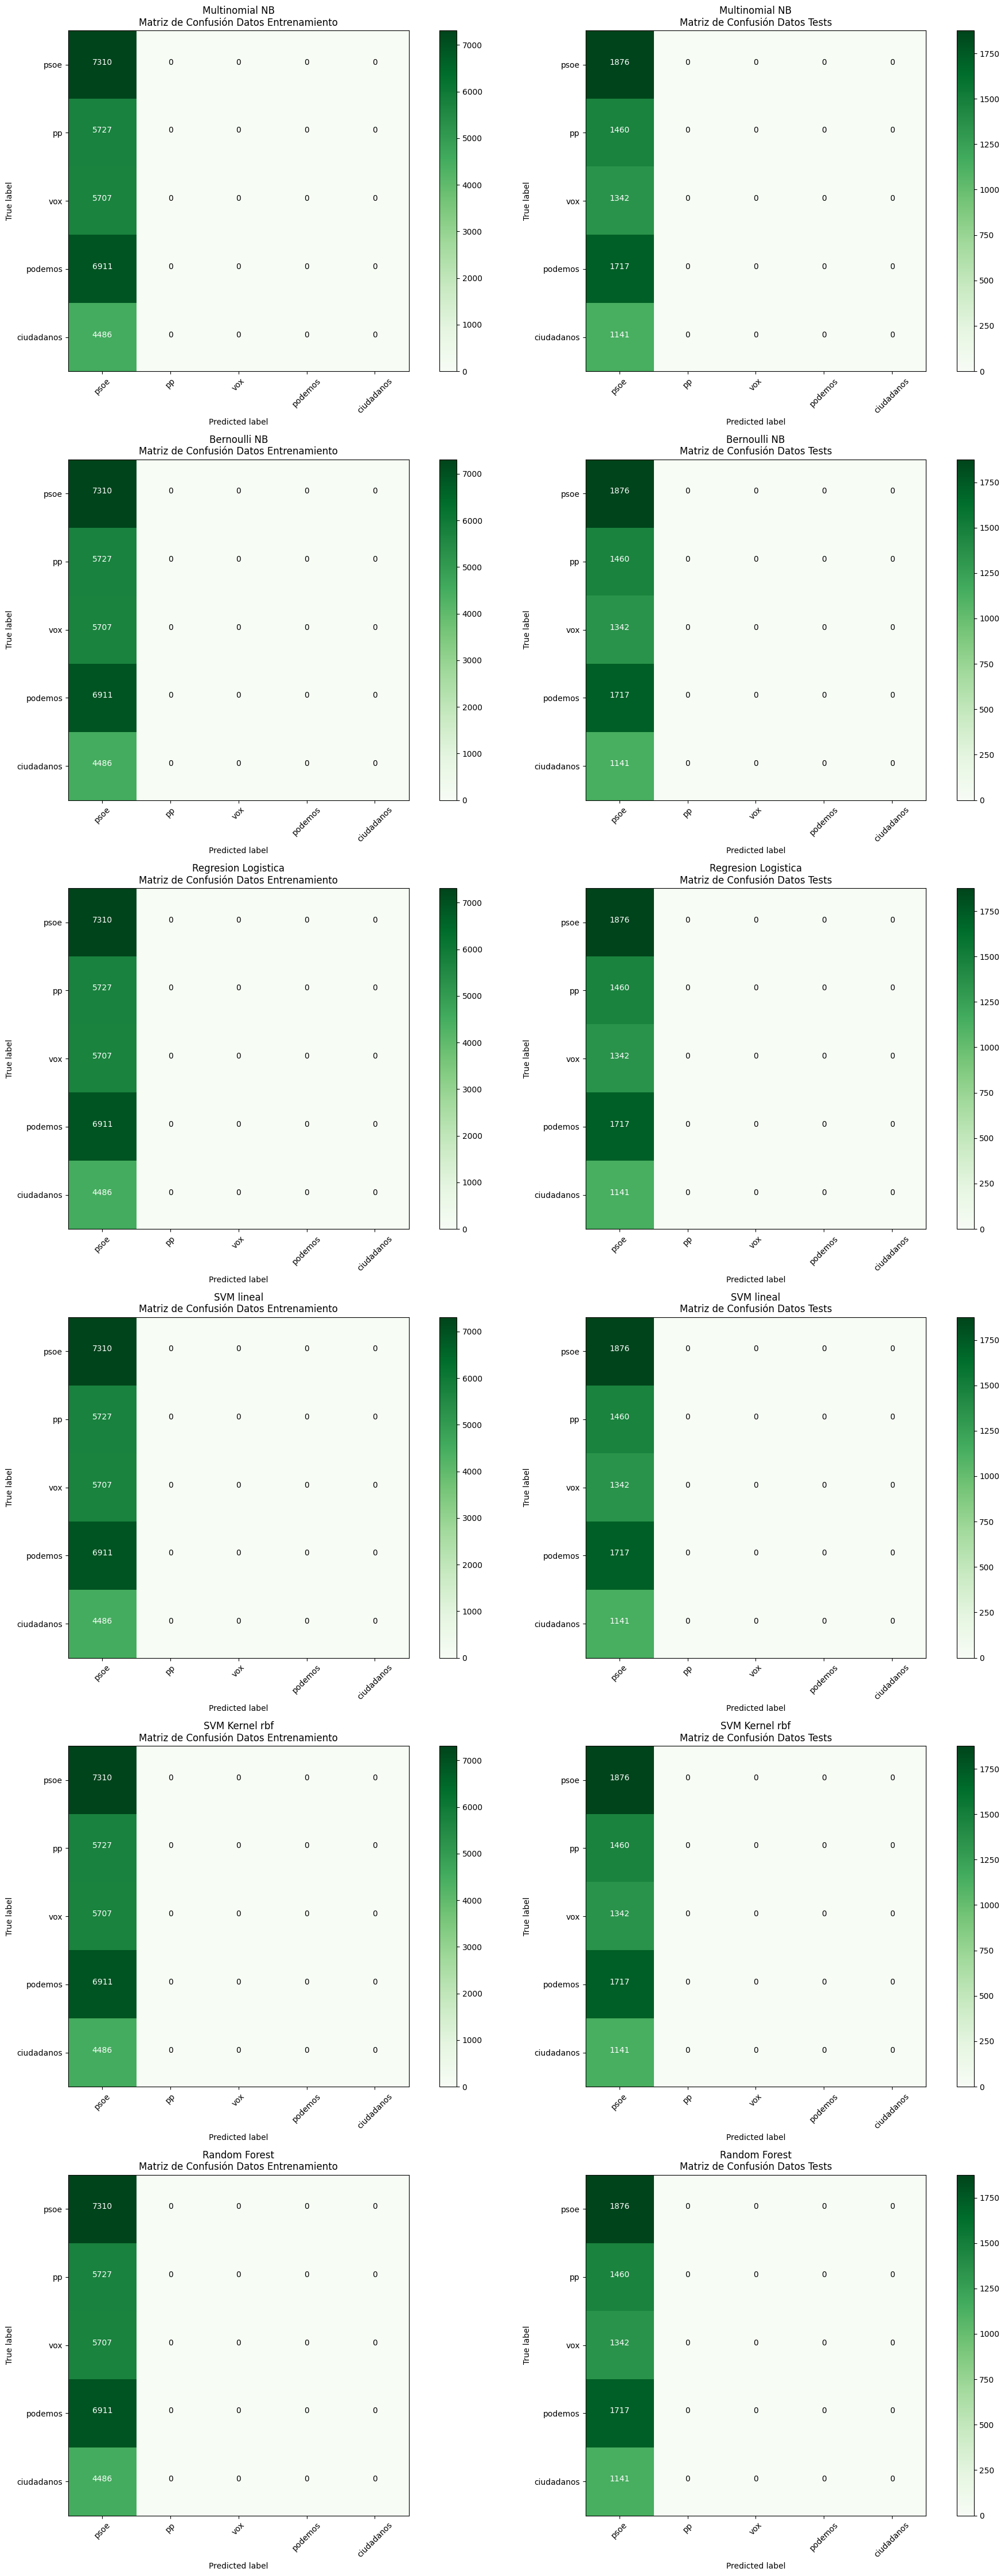

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

labels = ['psoe', 'pp', 'vox', 'podemos', 'ciudadanos']

# Obtenemos las Matrices de confusión
msc = list()
for k, v in clasificadores.items():
    print ('Obteniendo Matriz de Confusión de: {model}'.format(model=k))
    model = {}
    model['name'] = k
    y_pred_train = v.predict(X_train)
    y_pred_test = v.predict(X_test)
    model['confusion_matrix_train'] = confusion_matrix(y_true=y_train, y_pred=y_pred_train, labels=labels)
    model['confusion_matrix_test'] = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=labels)
    msc.append(model)

    
# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Pintamos las matrices de confusión
plt.figure(figsize=(20, 45))
pos = 0
for mc in msc:
    pos += 1
    plt.subplot(6, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_train'], classes=labels, 
                          title='{}\nMatriz de Confusión Datos Entrenamiento'.format(mc['name']))
    pos += 1
    plt.subplot(6, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_test'], classes=labels, 
                          title='{}\nMatriz de Confusión Datos Tests'.format(mc['name'] ))
plt.show()